In [1]:
using AutoRisk
using HDF5
using MultivariateStats
using PGFPlots

In [2]:
# extract features from some layer in the network
# note that input is normalized in this function 
function extract_features(network::Network, input::Array{Float64}, layer_index::Int)
    state = normalize_input!(network, input)
    for lidx in 1:layer_index
        state = state * network.weights[lidx] .+ network.biases[lidx]
        if lidx != layer_index
            network.nonlinearity(state)
        end
    end
    return state
end

extract_features (generic function with 1 method)

In [3]:
# load the network
# network_filepath = "../../data/networks/risk_.1_sec_no_bn.weights"
network_filepath = "../../data/networks/risk_10_sec_no_bn.weights"
network = Network(network_filepath);

In [14]:
# load the dataset
# dataset_filepath = "/Users/wulfebw/Dropbox/File_Transfers/risk/risk_.1_sec_full.h5"
dataset_filepath = "../../data/datasets/2_19/risk_10_sec_10_timesteps.h5"
debug_size = 100000
f = h5open(dataset_filepath, "r")
timestep = size(f["risk/features"], 2)
features = f["risk/features"][:,timestep,1:debug_size]
targets = f["risk/targets"][:,1:debug_size];

In [15]:
# extract features
layer_sizes = [size(b, 2) for b in network.biases]
input_dim = size(network.weights[1], 1)
num_layers = length(layer_sizes)
layer_index = 2
prediction_features = zeros(layer_sizes[2], debug_size)

for sample_idx in 1:size(features, 3)
    input = reshape(features[:,:,sample_idx], 1, input_dim)
    layer_features = extract_features(network, input, layer_index)
    prediction_features[:, sample_idx] = layer_features
end

In [16]:
println(prediction_features[:,1])

[-24.3618,10.0471,11.7666,-10.4121,-33.8472,-10.5322,-6.19564,6.02482,8.19831,-11.506,9.80373,-5.25954,-11.4465,-0.107033,14.2249,-1.18515,-6.74068,3.81241,12.7928,-36.7165,-23.9065,-10.9192,-3.66659,-36.58,-9.44926,-33.4868,-26.8414,1.92623,11.5381,10.0778,13.3987,-1.29641,1.14395,0.895003,3.47354,14.152,-6.48159,8.00732,0.28262,15.5977,15.7533,-29.8719,-13.9412,-9.95713,12.3988,-0.798497,8.39407,-37.0576,5.49883,-0.290768,8.26691,-5.62942,-4.44793,-4.05466,-8.71731,0.906829,-9.78044,-11.5573,-5.42811,-6.14092,-29.6458,-10.7395,1.85743,-32.8536]


In [17]:
# run PCA on the features in order to plot in 2d
M = fit(PCA, prediction_features; maxoutdim=2)
reduced_features = transform(M, prediction_features)
println(reduced_features[:,1])

[-52.0359,-9.97995]


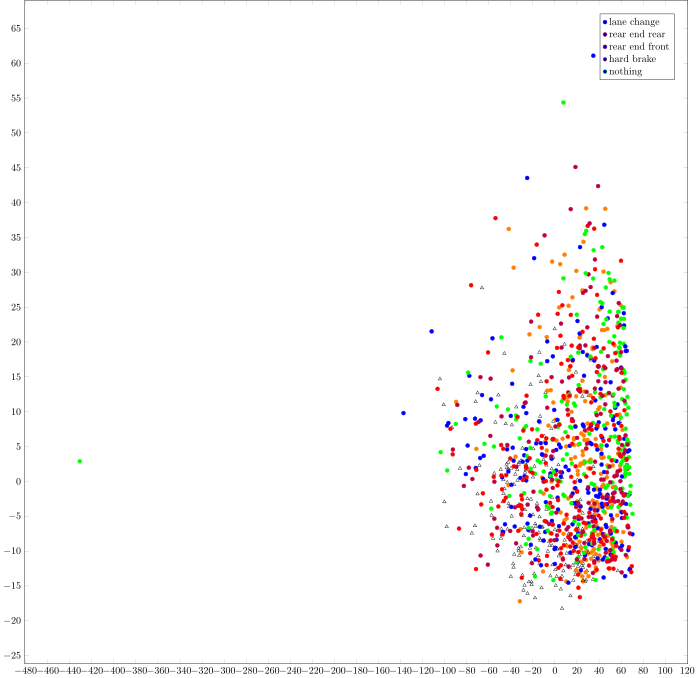

In [22]:
# take a look (color by target (ties go to the first target encountered))
sc = "{1={mark=*,blue,mark size=2}, 2={mark=*,red,mark size=2}, 3={mark=*,purple,mark size=2}, 4={mark=*,orange,mark size=2}, 5={mark=*,green,mark size=2}, 6={mark=triangle,black}}"
legend = ["lane change", "rear end rear", "rear end front", "hard brake", "nothing"]
colors = []
idxs = []
counts = zeros(6)
cat_max = 200
for i in 1:size(targets, 2)
    c = nothing
    if targets[1, i] > 0 && counts[1] < cat_max
        counts[1] += 1
        c = "1"
    elseif targets[2, i] > 0 && counts[2] < cat_max
        counts[2] += 1
        c = "2"
    elseif targets[3, i] > 0 && counts[3] < cat_max
        counts[3] += 1
        c = "3"
    elseif targets[4, i] > 0 && counts[4] < cat_max
        counts[4] += 1
        c = "4"
    elseif targets[5, i] > 0 && counts[5] < cat_max
        counts[5] += 1
        c = "5"
    elseif counts[6] < cat_max
        counts[6] += 1
        c = "6"
    end
    if c != nothing
        push!(idxs, i)
        push!(colors, c)
    end
end
a = PGFPlots.Axis(style="width=25cm, height=25cm");
scatter = Plots.Scatter(reduced_features[1,idxs], reduced_features[2,idxs], colors, scatterClasses=sc, legendentry=legend)
push!(a, scatter)
a